In [5]:
import numpy as np
import import_ipynb
from dumbAgent import DumbAgent
from randomAgent import RandomAgent
from environment import TicTacToe3D
import pygame, sys

In [6]:
# dummy_board = np.zeros((4, 4, 4), dtype=int)
# # floor, row, col
# dummy_board[0, 0, 0] = 1
# dummy_board[0, 1, 1] = 1
# dummy_board[0, 2, 2] = 1

# agent = DumbAgent()
# x = agent.findBestMove(dummy_board, 1)
# print(x)

In [7]:
def main(MODE, WAIT, LOG, agent1, agent2, env, player):
	whowin = 0
	while True:
		if MODE == 1:
			pass
		elif MODE == 2:
			# player vs bot
			command = input()

			if command == 'q':
				pygame.quit()
				break
			else:
				# For Player
				x, y = [int(a) for a in command.split(" ")]
				if not env.move(x, y, player):
					print('Invalid move')
					continue
				print(f"PLAYER: {x}, {y}")
				env.draw_figures()
				player = -player

				if (result := env.check()):
					print('-OX'[result], 'wins!')
					break

				# For BOT2
				botX, botyY = agent2.findBestMove(env.board, player)
				if LOG:
					print(f"BOT: {botX}, {botyY}")
				env.move(botX, botyY, player)
				env.draw_figures()
				player = -player
				
				if (result := env.check()):
					print('-OX'[result], 'wins!')
					break
		elif MODE == 3:
			# For BOT1
			mBot = agent1.findBestMove(env.board, player)

			if mBot is None:
				print("No moves left")
				if not WAIT:
					pygame.quit()
				whowin = 0
				break

			if LOG:
				print(f"BOT1: {mBot[0]}, {mBot[1]}")
			env.move(mBot[0], mBot[1], player)
			env.draw_figures()
			player = -player

			if (result := env.check()):
				print('-OX'[result], 'wins!')
				if not WAIT:
					pygame.quit()
				whowin = 1
				break

			# For BOT2
			mBot = agent2.findBestMove(env.board, player)

			if mBot is None:
				print("No moves left")
				if not WAIT:
					pygame.quit()
				whowin = 0
				break

			if LOG:
				print(f"BOT2: {mBot[0]}, {mBot[1]}")
			env.move(mBot[0], mBot[1], player)
			env.draw_figures()
			player = -player

			if (result := env.check()):
				print('-OX'[result], 'wins!')
				if not WAIT:
					pygame.quit()
				whowin = -1
				break
	
	return whowin


In [8]:
agent = DumbAgent()
agent1 = DumbAgent(depth=3)
# agent2 = DumbAgent(depth=2)
agent2 = RandomAgent()

# env = TicTacToe3D(headless=False)
# env.draw_lines()

player = 1

MODE = 3
WAIT = False
LOG = False
# 1 for player vs player
# 2 for player vs bot
# 3 for bot vs bot

rounds = 100
first_play_first_win = 0
first_play_second_win = 0
first_play_draw = 0
second_play_first_win  = 0
second_play_second_win  = 0
second_play_draw = 0

for_plot = []
for_plot_agent1_first = []
for_plot_agent2_first = []

for i in range(rounds):
  env = TicTacToe3D(headless=False)
  env.draw_lines()

  if i < rounds // 2:
    first_agent = agent1
    second_agent = agent2
  else:
    first_agent = agent2
    second_agent = agent1

  game_result = main(MODE=MODE, WAIT=WAIT, LOG=LOG, agent1=first_agent, agent2=second_agent, env=env, player=player)

  if i < rounds // 2:
    if (game_result == 1):
      first_play_first_win += 1
    elif (game_result == -1):
      first_play_second_win += 1
    else:
      first_play_draw += 1
    for_plot_agent1_first.append([first_play_first_win, first_play_second_win, first_play_draw])
  else:
    if (game_result == 1):
      second_play_first_win += 1
    elif (game_result == -1):
      second_play_second_win += 1
    else:
      second_play_draw += 1
    for_plot_agent2_first.append([second_play_first_win, second_play_second_win, second_play_draw])

  for_plot.append([first_play_first_win + second_play_first_win, first_play_second_win + second_play_second_win, first_play_draw + second_play_draw])

  if i == (rounds // 2) - 1:
    print(f"First {rounds // 2} round, First win: {first_play_first_win}, Second win: {first_play_second_win}, Draw: {first_play_draw}")
  if i == rounds - 1:
    print(f"Last {rounds // 2} round, First win: {second_play_first_win}, Second win: {second_play_second_win}, Draw: {second_play_draw}")

Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
No moves left
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player A wins!
Player B wins!
Player A wins!
Player A wins!
Player A wins!
First 50 round, First win: 48, Second win: 1, Draw: 1
Player B wins!
Player A wins!
Player B wins!
Player B wins!
Player B wins!
Player B wins!
Player B wins!
Player B wins!
Player B wins!
Player B wins!
Player B wins!
Player B wins!
Player B wins!
Pl

In [16]:
print(f"In {rounds} round")
print(f"First player win: {first_play_first_win + second_play_first_win}, Second player win: {first_play_second_win + second_play_second_win}")
print(f"Agent A win: {first_play_first_win + second_play_second_win}, Agent B win: {first_play_second_win + second_play_first_win}")
print(f"Draw: {first_play_draw + second_play_draw}")

In 100 round
First player win: 50, Second player win: 48
Agent A win: 95, Agent B win: 3
Draw: 2


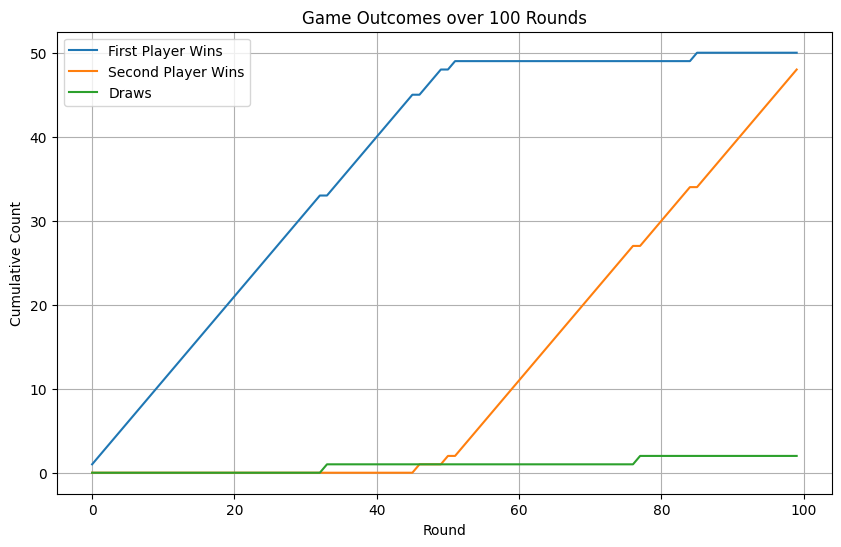

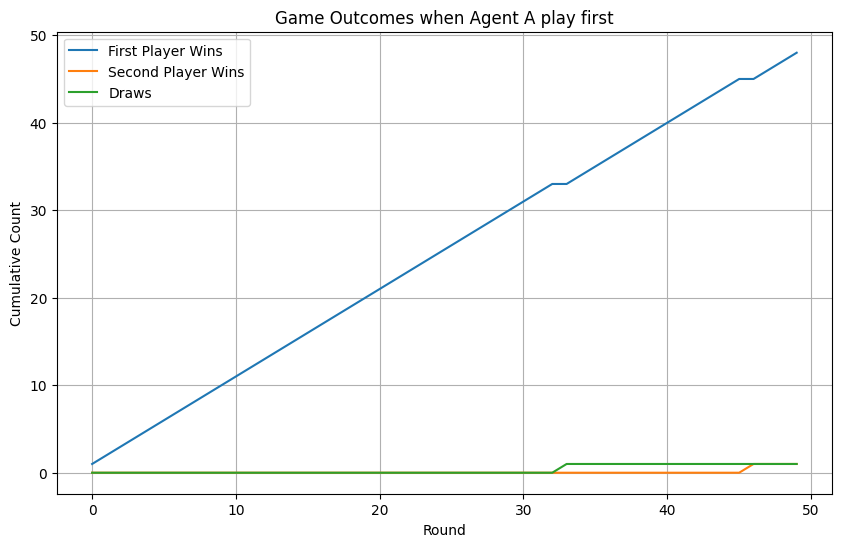

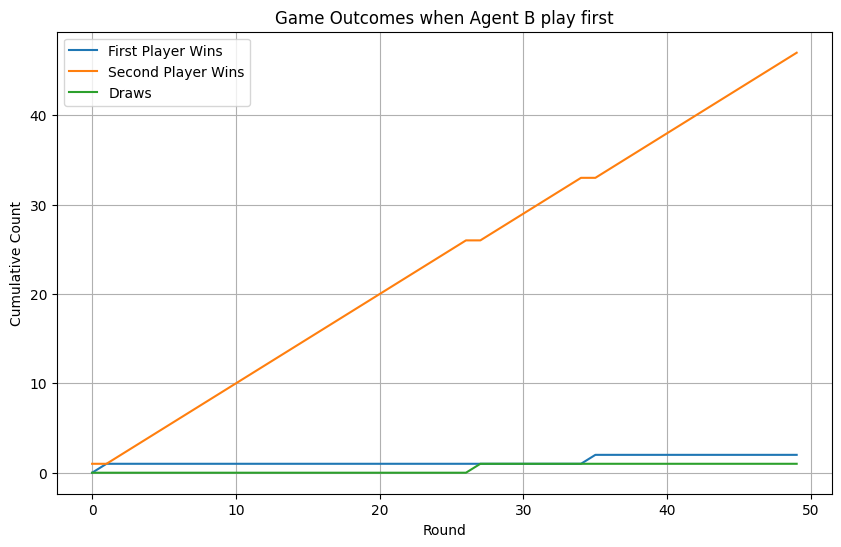

In [17]:
import matplotlib.pyplot as plt

# Unpacking the results
first_wins, second_wins, draws = zip(*for_plot)
fisrt_play_first_wins, fisrt_play_second_wins, fisrt_play_draws = zip(*for_plot_agent1_first)
second_play_first_wins, second_play_second_wins, second_play_draws = zip(*for_plot_agent2_first)

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(first_wins, label='First Player Wins')
plt.plot(second_wins, label='Second Player Wins')
plt.plot(draws, label='Draws')
plt.title(f'Game Outcomes over {rounds} Rounds')
plt.xlabel('Round')
plt.ylabel('Cumulative Count')
plt.legend()
plt.grid(True)
plt.show()

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(fisrt_play_first_wins, label='First Player Wins')
plt.plot(fisrt_play_second_wins, label='Second Player Wins')
plt.plot(fisrt_play_draws, label='Draws')
plt.title(f'Game Outcomes when Agent A play first')
plt.xlabel('Round')
plt.ylabel('Cumulative Count')
plt.legend()
plt.grid(True)
plt.show()

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(second_play_first_wins, label='First Player Wins')
plt.plot(second_play_second_wins, label='Second Player Wins')
plt.plot(second_play_draws, label='Draws')
plt.title(f'Game Outcomes when Agent B play first')
plt.xlabel('Round')
plt.ylabel('Cumulative Count')
plt.legend()
plt.grid(True)
plt.show()